# Supply Chain Disruption Analysis

The objective is to the ETL the data (Extract, Transform, Load) then analyze the transformed data to see the impact of the Supply Chain Disruption.  

The SQL query service will be used to transform data from a Cloud Object Storage bucket that contains a sample database to a Cloud Object Storage bucket used for the Watson Studio project. The queries run by the SQL Query service will read the data out of the sample data Cloud Object Storage bucket and write the result to the Cloud Object Storage bucket used for the Watson Studio project.  Once the transformed data is in the Cloud Object Storage bucket we use pixiedust to visualize the data to see the impact of the Supply Chain Disruption.

## Analysis

* Orders by supplier region
* Orders by product
* Orders by customer country
* Customers impacted

<div class="alert alert-block alert-info">This notebook is intended for Cloud Pak for Data as a Service (CPDaas) on Cloud and runs on Python 3.6.</div>
</div>

## Table of Contents

1. [Prerequisites](#cell0)
1. [Load Python modules](#cell1)
1. [Create the SQL Query client](#cell2)
1. [Submit the query](#cell3)
1. [Visualize the data](#cell4)
1. [Results of impacted customers](#cell5)

<a id = "cell0"></a>
## Prerequisites

* Project token for this Watson Studio project
* Cloud Object Storage bucket with sample data (we will use sample data already available to the SQL Query service)
* Cloud Object Storage bucket used for the query results  (we will use Watson Studio project bucket)
* SQL Query instance
* An API Key used to access the SQL Query instance and the Cloud Object Storage buckets



### Insert the project token to set the bucket for SQL Query results

Inserting the project token:

Click the More option in the toolbar above (the three stacked dots) and select Insert project token.

    If you haven't created an access token for this project before, you will see a dialog that asks you to create one first. Follow the link to open your project settings, scroll down to Access tokens and click New token. Give the token a custom name and make sure you select Editor as Access role for project. After you have created your access token you can come back to this notebook, select the empty cell below and again select Insert project token from the toolbar at the top.

This will add a new cell at the top of your notebook with content that looks like this:

```
#### @hidden_cell
#### The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='<some id>', project_access_token='<some access token>')
pc = project.project_context
```

Leave that cell content as inserted and run the cell.

### Create SQL Query instance and get CRN

1. At the top left corner of the screen, open the **Hamburger menu > Services > Services catalog**
2. Check Databases checkbox on the lefthand side
3. Click on the **SQL Query** tile
4. Click **Create** and choose Location: Dallas, Standard Plan
5. Open **SQL Query** service instance  (will launch out to another tab) 
6. Click the **Copy** button to the right of the CRN and save in a text file
7. Navigate back to the Watson Studio notebook browser tab

### Create IAM user apikey 
1. At the top corner of the screen, open the **Hamburger menu > Administer -> Access (IAM)**
2. Choose **API Keys**
3. Create an IBM Cloud API key
4. Give the API key a name
5. Click **Create** 
6. Click **Copy** button and save in the same text file as the CRN

Run the Notebook and paste in the CRN and apikey from the text file.

In [2]:
import getpass

sqlquery_crn=getpass.getpass('Enter SQL Query CRN (leave empty to use previous one): ') or sqlquery_crn
if len(sqlquery_crn) == 0:
    print("Error: You cannot run the notebook without a SQL Query CRN!")
    
apikey=getpass.getpass('Enter the platform API Key to use with the SQL Query Instance (leave empty to use previous one): ') or apikey
if len(apikey) == 0:
    print("Error: You cannot run the notebook without an API Key!")
    
targeturl=''
cos_bucket = project.get_metadata()['entity']['storage']['properties']
targeturl="cos://" + cos_bucket['bucket_region'] + "/" + cos_bucket['bucket_name'] + "/"

Enter SQL Query CRN (leave empty to use previous one): ········
Enter the platform API Key to use with the SQL Query Instance (leave empty to use previous one): ········


<a id = "cell1"></a>
## Load the Python modules 

`ibmcloudsql` is the package for using the SQL Query service.

PixieDust is the package for visualization.

In [ ]:
!conda install pyarrow
!conda install sqlparse

!pip install --upgrade --user ibmcloudsql
!pip install --user --upgrade pixiedust

import ibmcloudsql
from pixiedust.display import *
import pandas as pd

import sqlparse
from pygments import highlight
from pygments.lexers import get_lexer_by_name
from pygments.formatters import HtmlFormatter, Terminal256Formatter

<a id = "cell2"></a>
## Create the SQL Query client 

The SQL Query client isused to send queries to the SQL Query service. As the notebook is running you can watch the queries run in Your SQL Query web console.

In [4]:
sqlClient = ibmcloudsql.SQLQuery(apikey, sqlquery_crn, client_info='Supply Chain Disruption Analysis')
sqlClient.logon()
print('\nYour SQL Query web console link:\n')
sqlClient.sql_ui_link()


Your SQL Query web console link:

https://sql-query.cloud.ibm.com/sqlquery/?instance_crn=crn:v1:bluemix:public:sql-query:us-south:a/23f1e9853c41f6b566e71689ed8a1363:c49157a5-b308-4f6b-972c-455082a8f47e::


### Sample database
The sample database 14 tables and the table relationships are showcased in the following entity relationship diagram.
We will be querying a subset of these tables for the Supply Chain Disruption analysis.

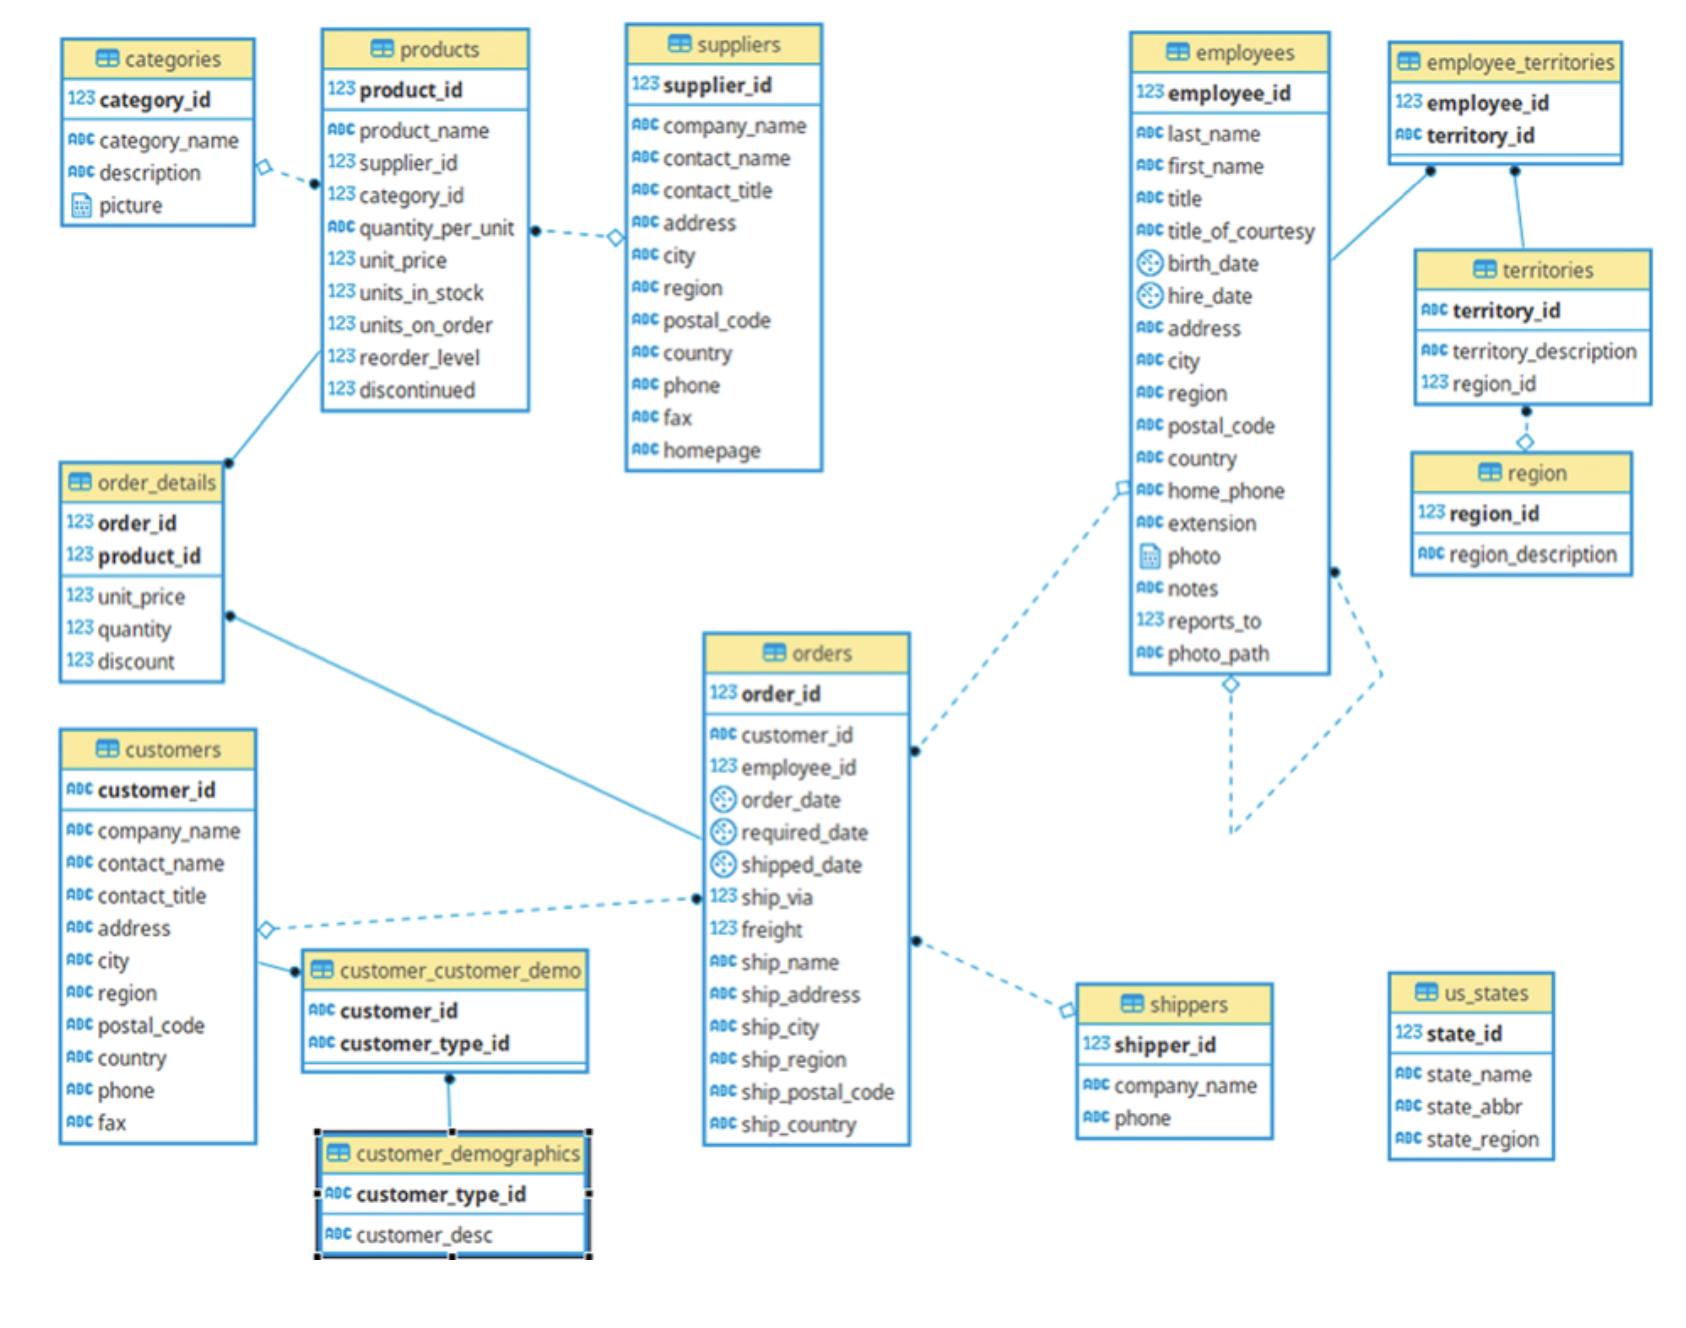

### Before and After query with supply chain cutoff in LA
This query puts together the state of the supply chain before the disruption and after the disruption so that the before and after impact can be visualized on the charts.

In [5]:
sql=f"""select 'Before Disruption' as period
       ,s.supplierID, s.companyName as supplier_company_name, s.region as supplier_region
       ,p.productID, p.productName
	   ,o.orderID
	   ,c.customerID, c.companyName as customer_company_name, c.region as customer_region, c.country as customer_country
       from cos://us-geo/sql/suppliers.parquet stored as parquet s, 
            cos://us-geo/sql/products.parquet stored as parquet p,
            cos://us-geo/sql/order_details.parquet stored as parquet od,
            cos://us-geo/sql/orders.parquet stored as parquet o,
            cos://us-geo/sql/customers.parquet stored as parquet c
       where s.supplierID = p.supplierID 
	   and p.productID = od.productID
       and od.orderID = o.orderID 
       and o.customerID = c.customerID
       and s.country='USA'
	   
	   UNION
	   
	   select 'After Disruption' as period
	   ,s.supplierID, s.companyName as supplier_company_name, s.region as supplier_region
       ,p.productID, p.productName
	   ,o.orderID
	   ,c.customerID, c.companyName as customer_company_name, c.region as customer_region, c.country as customer_country
       from cos://us-geo/sql/suppliers.parquet stored as parquet s, 
            cos://us-geo/sql/products.parquet stored as parquet p,
            cos://us-geo/sql/order_details.parquet stored as parquet od,
            cos://us-geo/sql/orders.parquet stored as parquet o,
            cos://us-geo/sql/customers.parquet stored as parquet c
       where s.supplierID = p.supplierID 
	   and p.productID = od.productID
       and od.orderID = o.orderID 
       and o.customerID = c.customerID
       and s.country='USA' and s.region <> 'LA'"""
if " INTO " not in sql:
    sql += ' INTO {} STORED AS CSV'.format(targeturl)
    
formatted_sql = sqlparse.format(sql, reindent=True, indent_tabs=True, keyword_case='upper')
lexer = get_lexer_by_name("sql", stripall=True)
formatter = Terminal256Formatter(style='tango')
result = highlight(formatted_sql, lexer, formatter)
from IPython.core.display import display, HTML

print('\nYour SQL statement is:\n')
print(result)


Your SQL statement is:

SELECT 'Before Disruption' AS period ,
	s.supplierID,
	s.companyName AS supplier_company_name,
	s.region AS supplier_region ,
	p.productID,
	p.productName ,
	o.orderID ,
	c.customerID,
	c.companyName AS customer_company_name,
	c.region AS customer_region,
	c.country AS customer_country
FROM cos://us-geo/SQL/suppliers.parquet stored AS parquet s,
	cos://us-geo/SQL/products.parquet stored AS parquet p,
	cos://us-geo/SQL/order_details.parquet stored AS parquet od,
	cos://us-geo/SQL/orders.parquet stored AS parquet o,
	cos://us-geo/SQL/customers.parquet stored AS parquet c
WHERE s.supplierID = p.supplierID
		AND p.productID = od.productID
		AND od.orderID = o.orderID
		AND o.customerID = c.customerID
		AND s.country='USA'
UNION
SELECT 'After Disruption' AS period ,
	s.supplierID,
	s.companyName AS supplier_company_name,
	s.region AS supplier_region ,
	p.productID,
	p.productName ,
	o.orderID ,
	c.customerID,
	c.companyName AS customer_company_name,
	c.region AS cus

<a id = "cell3"></a>
## Submit the query
Now that we have written the query above its time to submit it to the SQL Query service and wait for the result 

In [6]:
jobId = sqlClient.submit_sql(sql)
print("SQL query submitted and running in the background. jobId = " + jobId)
print("Job status for " + jobId + ": " + sqlClient.get_job(jobId)['status'])
job_status = sqlClient.wait_for_job(jobId)
print("Job " + jobId + " terminated with status: " + job_status)
if job_status == 'failed':
    details = sqlClient.get_job(jobId)
    print("Error: {}\nError Message: {}".format(details['error'], details['error_message']))
    
disrupt_df1 = sqlClient.get_result(jobId)

SQL query submitted and running in the background. jobId = 71f8291a-04f4-4392-abd2-b969cfd1d0c6
Job status for 71f8291a-04f4-4392-abd2-b969cfd1d0c6: running
Job 71f8291a-04f4-4392-abd2-b969cfd1d0c6 terminated with status: completed


<a id = "cell4"></a>
## Visualize the data
We will visualize different aspects of the supply chain interuption using pixiedust bar charts

In [7]:
from pixiedust.display import *
display(disrupt_df1)


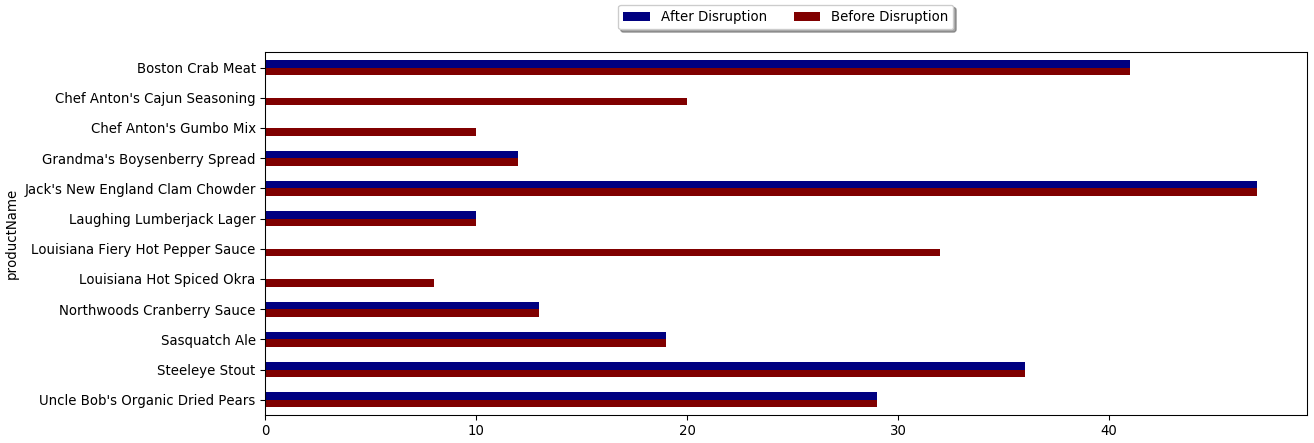

In [ ]:
from pixiedust.display import *
display(disrupt_df1)

In [ ]:
from pixiedust.display import *
display(disrupt_df1)

<a id = "cell5"></a>
## Results of impacted customers

###  Query the data frame in memory

Query the data set in memory to get a list of the customers impacted by the supply chain disruption.
Query the data set in memory is faster then submitting another query to the SQL Query service and waiting for the result.

In [10]:
disrupt_df2 = disrupt_df1.copy()
filter1 = disrupt_df2["period"]=="Before Disruption"
filter2 = disrupt_df2["supplier_region"] == "LA"
disrupt_df2.where(filter1 & filter2, inplace = True) 

df_customers = disrupt_df2[['customerID', 'customer_company_name']]
unique_customers = df_customers.drop_duplicates()
unique_customers = unique_customers.dropna()
display(unique_customers)


## Summary

Congratulations! You have completed the notebook and learned to Extract, Transform, Load data from a Cloud Object Storage bucket and then analyze the transformed data to see the impact of the Supply Chain Disruption by using SQL query service. You have also learned to write the result to a COS bucket connected to the project, and visualize the data to see the impact using PixieDust. Finally you are able to view the results: a list of customers who are affected.

### Author

**Mike L. Lamb**, Offering Manager of IBM Cloud Services Integration and Cloud Object Storage.

# <hr>
Copyright &copy; IBM Corp. 2020. This notebook and its source code are released under the terms of the MIT License.

<div style="background:#F5F7FA; height:110px; padding: 2em; font-size:14px;">
<span style="font-size:18px;color:#152935;">Love this notebook? </span>
<span style="font-size:15px;color:#152935;float:right;margin-right:40px;">Don't have an account yet?</span><br>
<span style="color:#5A6872;">Share it with your colleagues and help them discover the power of Watson Studio!</span>
<span style="border: 1px solid #3d70b2;padding:8px;float:right;margin-right:40px; color:#3d70b2;"><a href="https://ibm.co/wsnotebooks" target="_blank" style="color: #3d70b2;text-decoration: none;">Sign Up</a></span><br>
</div>